In [1]:
from load_cifar_10 import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim

In [2]:
## data load

cifar_10_dir = 'cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
load_cifar_10_data(cifar_10_dir)

def Processing_data(train, test):
    #change dtype
    train = np.array(train, dtype=np.float64)
    test = np.array(test, dtype=np.float64)
    
    #Reshaping
    train = np.reshape(train, (train.shape[0], -1))
    test = np.reshape(test, (test.shape[0], -1))
    
    #Normalizing
    mean_image = np.mean(train, axis = 0)
    #print(train.dtype)
    train -= mean_image
    test -= mean_image
    
    return train, test

train_data, test_data = Processing_data(train_data, test_data)

In [3]:
##############
##Architecture
##############
input_size = 32 * 32 * 3
hidden_size = 50
output_size = 10
epoch_size = 100
batch_size = 100
learning_rate = 0.0001
dropout_prob = 0.5

N = train_data.shape[0]
M = test_data.shape[0] # 새롭게 추가

In [4]:
### train 함수
def mytrain(net):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    history = {'val_acc': [],'val_loss': [], 'train_acc':[], 'train_loss':[]} #기록해서 그림 그리자!
    start_time = time.time()  
    net.train() # train 구분
    for i in range(epoch_size):
        correct = 0
        total = 0
        running_loss = 0
        for j in range(N//batch_size):
            batch_mask = np.random.choice(N, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
            x_batch = torch.FloatTensor(train_data[batch_mask])
            t_batch = torch.LongTensor(train_labels[batch_mask])

            # Gradient buffer를 0으로 초기화
            optimizer.zero_grad()

            # Forward
            outputs = net(x_batch)
            # Backward
            loss = criterion(outputs, t_batch)
            loss.backward()
            # Update the weights
            optimizer.step()

            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += t_batch.size(0)
            correct += (predicted == t_batch).sum().item()
            running_loss += loss.item()

        acc = 100*correct/total    
        history['train_loss'].append(running_loss / N) # 수정
        history['train_acc'].append(acc)

        if i % 10 == 9: # print every 10 epochs 

            print('[%d] loss: %.3f acc: %.3f ' %
                  (i + 1, running_loss, acc)) # 수정
            print('Accuracy of the network on the 50000 train images: %d %%' %  acc)
            running_loss = 0.0

        # Test
        correct = 0
        total = 0
        val_loss = 0
        net.eval() # test 구분
        with torch.no_grad():
            for k in range(M//batch_size):
                batch_mask = np.random.choice(M, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
                x_batch = torch.FloatTensor(test_data[batch_mask])
                t_batch = torch.LongTensor(test_labels[batch_mask])

                 # Forward
                outputs = net(x_batch)

                # loss
                loss = criterion(outputs, t_batch)

                # Statistics
                _, predicted = torch.max(outputs.data, 1)
                total += t_batch.size(0)
                correct += (predicted == t_batch).sum().item()
                val_loss += loss.item()

            #accuracy와 loss를 기록해둡시다.
            acc = 100*correct/total
            history["val_acc"].append(acc)
            history["val_loss"].append(val_loss / M) # 수정

            if i % 10 == 9: # print every 10 epochs
                print('[%d] loss: %.3f acc: %.3f ' %
                      (i + 1, val_loss, acc))
                print('Accuracy of the network on the 10000 test images: %d %%' % acc)
                val_loss = 0.0

    print("Time : ", time.time()-start_time, "sec")
    
    #그래프 그리기
    fig = plt.figure()
    ax_acc = fig.add_subplot(111)
    ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
    #plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
    plt.xlabel('epochs')
    plt.ylabel('Validation Accuracy(%)')
    ax_acc.grid(linestyle='--', color='lavender')
    ax_loss = ax_acc.twinx()
    ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
    #plt.text(3, 2.2, "<----------------오차", verticalalignment='top', horizontalalignment='left')
    plt.ylabel('Validation Error')
    ax_loss.yaxis.tick_right()
    ax_loss.grid(linestyle='--', color='lavender')

    # 그래프 표시
    plt.show()

In [5]:
####################
### Model 
###################
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.kaiming_normal_(self.fc1.weight) # ReLU에는 he initialization이 더 적합하다.
        self.relu = nn.ReLU()     
        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


[10] loss: 2660.766 acc: 37.570 
Accuracy of the network on the 50000 train images: 37 %
[10] loss: 674.530 acc: 32.000 
Accuracy of the network on the 10000 test images: 32 %
[20] loss: 1278.720 acc: 43.084 
Accuracy of the network on the 50000 train images: 43 %
[20] loss: 376.047 acc: 33.780 
Accuracy of the network on the 10000 test images: 33 %
[30] loss: 878.997 acc: 47.088 
Accuracy of the network on the 50000 train images: 47 %
[30] loss: 278.598 acc: 35.710 
Accuracy of the network on the 10000 test images: 35 %
[40] loss: 750.073 acc: 49.958 
Accuracy of the network on the 50000 train images: 49 %
[40] loss: 227.133 acc: 37.550 
Accuracy of the network on the 10000 test images: 37 %
[50] loss: 697.521 acc: 52.174 
Accuracy of the network on the 50000 train images: 52 %
[50] loss: 210.123 acc: 39.230 
Accuracy of the network on the 10000 test images: 39 %
[60] loss: 663.194 acc: 53.730 
Accuracy of the network on the 50000 train images: 53 %
[60] loss: 197.008 acc: 41.110 
Acc

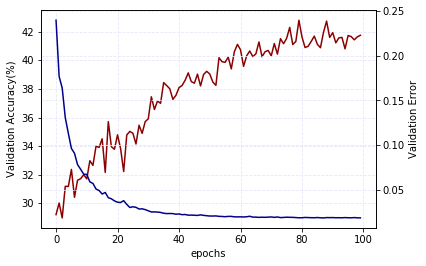

In [6]:
learning_rate = 0.0001
mytrain(net)

In [7]:
# [100] loss: 49.336 acc: 65.346 
# Accuracy of the network on the 50000 train images: 65 %
# [100] loss: 17.843 acc: 44.360 
# Accuracy of the network on the 10000 test images: 44 %

############## 피드백 반영 ##############

# [100] loss: 615.975 acc: 56.534 
# Accuracy of the network on the 50000 train images: 56 %
# [100] loss: 185.927 acc: 41.750 
# Accuracy of the network on the 10000 test images: 41 %

# 왜 떨어졌을까..? dropout이나 BN을 사용하지 않는데 test와 train을 구분해줘서 그런건가..?

### Batch_norm

In [8]:
class Batch_Net(nn.Module):
    def __init__(self):
        super(Batch_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

batch_net = Batch_Net()
print(batch_net)

Batch_Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


[10] loss: 803.668 acc: 44.196 
Accuracy of the network on the 50000 train images: 44 %
[10] loss: 162.919 acc: 42.190 
Accuracy of the network on the 10000 test images: 42 %
[20] loss: 753.067 acc: 48.026 
Accuracy of the network on the 50000 train images: 48 %
[20] loss: 155.101 acc: 45.110 
Accuracy of the network on the 10000 test images: 45 %
[30] loss: 721.279 acc: 50.524 
Accuracy of the network on the 50000 train images: 50 %
[30] loss: 150.551 acc: 47.440 
Accuracy of the network on the 10000 test images: 47 %
[40] loss: 698.007 acc: 51.776 
Accuracy of the network on the 50000 train images: 51 %
[40] loss: 147.335 acc: 47.740 
Accuracy of the network on the 10000 test images: 47 %
[50] loss: 678.375 acc: 53.168 
Accuracy of the network on the 50000 train images: 53 %
[50] loss: 146.231 acc: 48.280 
Accuracy of the network on the 10000 test images: 48 %
[60] loss: 658.566 acc: 54.660 
Accuracy of the network on the 50000 train images: 54 %
[60] loss: 144.745 acc: 48.700 
Accur

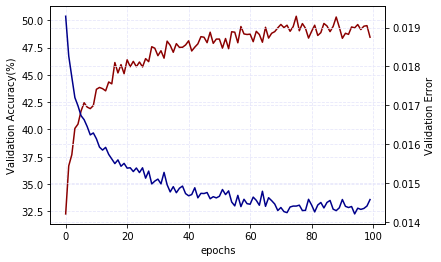

In [9]:
learning_rate = 0.002 
# Batch Normalization의 장점은 Learning Rate를 올려도 된다는 것 = 빠른 학습
# 또한 정규화 효과도 있기 때문에 Dropout도 필요하지 않음

mytrain(batch_net)

In [10]:
# [100] loss: 61.018 acc: 57.932 
# Accuracy of the network on the 50000 train images: 57 %
# [100] loss: 15.273 acc: 46.900 
# Accuracy of the network on the 10000 test images: 46 %
# Time :  297.6024739742279 sec

############## 피드백 반영 ##############

# [100] loss: 607.926 acc: 58.260 
# Accuracy of the network on the 50000 train images: 58 %
# [100] loss: 145.801 acc: 48.450 
# Accuracy of the network on the 10000 test images: 48 %

# 약간 더 좋아졌다.

### Dropout

In [11]:
class Drop_Net(nn.Module):
    def __init__(self):
        super(Drop_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

drop_net = Drop_Net()
print(drop_net)

Drop_Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


[10] loss: 2241.151 acc: 34.570 
Accuracy of the network on the 50000 train images: 34 %
[10] loss: 557.553 acc: 29.910 
Accuracy of the network on the 10000 test images: 29 %
[20] loss: 1154.000 acc: 39.816 
Accuracy of the network on the 50000 train images: 39 %
[20] loss: 321.985 acc: 31.380 
Accuracy of the network on the 10000 test images: 31 %
[30] loss: 879.661 acc: 43.224 
Accuracy of the network on the 50000 train images: 43 %
[30] loss: 245.934 acc: 34.320 
Accuracy of the network on the 10000 test images: 34 %
[40] loss: 790.787 acc: 45.750 
Accuracy of the network on the 50000 train images: 45 %
[40] loss: 210.864 acc: 37.100 
Accuracy of the network on the 10000 test images: 37 %
[50] loss: 743.629 acc: 48.162 
Accuracy of the network on the 50000 train images: 48 %
[50] loss: 198.525 acc: 39.480 
Accuracy of the network on the 10000 test images: 39 %
[60] loss: 715.953 acc: 49.202 
Accuracy of the network on the 50000 train images: 49 %
[60] loss: 192.601 acc: 38.830 
Acc

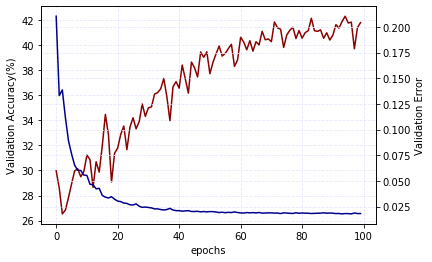

In [12]:
learning_rate = 0.0001
mytrain(drop_net)

In [13]:
# [100] loss: 89.730 acc: 36.706 
# Accuracy of the network on the 50000 train images: 36 %
# [100] loss: 19.939 acc: 31.840 
# Accuracy of the network on the 10000 test images: 31 %
# Time :  281.5744514465332 sec

# dropout을 하니 오히려 성능이 매우 떨어지는 결과가 나왔다. 
# 1. 마지막 Layer 직전에는 적합하지 않다. dropout으로 인한 에러를 수정하지 못 하므로 성능이 떨어지게 된다.
# 2. dropout을 사용하면 수렴하기 전에는 성능이 더 안 좋게 된다. 수렴할때까지 모델을 돌릴 것이 아니라면 사용하지 않는 것이 좋다.
# 3. batch normalizaiton 으로 인해 잘 사용하지 않는다.
# 출처 : stats.stackexchange.com/questions/299292

############## 피드백 반영 ##############

# Accuracy of the network on the 50000 train images: 52 %
# [100] loss: 182.794 acc: 41.810 
# Accuracy of the network on the 10000 test images: 41 %
# Time :  188.52673316001892 sec

# 엄청 많이 좋아졌다. 모델에 train과 test 구분을 해주는게 굉장히 중요한 것 같다. 하지만 여전히 dropout 사용 전에 비해서 안 좋다. (당연한 결과!)

In [14]:
### 피드백 반영
# 1. ReLU에는 he initialization이 더 적합하다고 하여 수정했습니다.
# 2. 코드 잘못됐다고 한 부분 (running loss와 val loss 부분) 수정했습니다.
# 3. model.train()과 model.eval() 추가했습니다.